In [1]:
import geopandas as gpd 
import rioxarray as rxr 
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import rasterio.features
from shapely.geometry import shape, MultiPolygon
from utils.read_files import make_default_path, read_from_control

In [2]:
basin = 'EastRiver'
controlFile = f'control_{basin}.txt'

# basin name and outlet gauge id
root_path = Path(read_from_control(controlFile, "root_path"))

In [3]:
# load the basin shapefile
basin_shp = gpd.read_file(root_path / f"domain_{basin}/shapefiles/catchment/{basin}.shp")
# load the basin raster dem
dem = rxr.open_rasterio(root_path / f"domain_{basin}/parameters/dem/dem.tif")

# convert basin crs to dem crs
basin_shp = basin_shp.to_crs(dem.rio.crs)


In [4]:
elev_bands = np.arange(dem.min().round(-2), dem.max().round(-2)+ 100, 500)
gdf = gpd.GeoDataFrame()
for i,band in enumerate(elev_bands):
    if i < len(elev_bands) - 1:
        # create a mask for the current elevation band
        mask = (dem >= band) & (dem < elev_bands[i+1])
        # apply the mask to the dem
        dem_masked = dem.where(mask)
        # plot the masked dem
        
        # Load the DEM mask (binary mask where 1 = valid, 0 = no data)
        mask = dem_masked.squeeze()

        # Ensure the mask is binary (1 = areas of interest, 0 = background)
        binary_mask = np.where(mask > 0, 1, 0).astype(np.uint8)

        # Extract polygons from the binary mask
        shapes = rasterio.features.shapes(binary_mask, transform=mask.rio.transform())

        # Convert extracted shapes to a MultiPolygon
        polygons = [shape(geom) for geom, value in shapes if value == 1]
        multi_polygon = MultiPolygon(polygons)

        # (Optional) Save to a GeoJSON file
        # add to gdf
        if i == 0:
            gdf = gpd.GeoDataFrame(geometry=[multi_polygon], crs=dem.rio.crs)
        else:
            gdf = gdf.merge(gpd.GeoDataFrame(geometry=[multi_polygon], crs=dem.rio.crs), how='outer')
    
# dem.squeeze().plot()

In [5]:
hru_area = gdf.area
gdf['HRU_area'] = hru_area

# convert
gdf = gdf.to_crs(epsg=4326)


In [6]:
# add center lat and center lon
gdf['center_lat'] = gdf.geometry.centroid.y
gdf['center_lon'] = gdf.geometry.centroid.x

/tmp/ipykernel_20466/3954503645.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['center_lat'] = gdf.geometry.centroid.y
/tmp/ipykernel_20466/3954503645.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['center_lon'] = gdf.geometry.centroid.x


In [7]:
# set the HRU_ID and GRU_IDs
gdf['HRU_ID'] = gdf.index
gdf['GRU_ID'] = "09112500"
# Sort
gdf = gdf[['GRU_ID', 'HRU_ID', 'HRU_area', 'center_lat', 'center_lon', 'geometry']]
gdf = gdf.sort_values(by=["GRU_ID","HRU_ID"])

In [8]:
# save the gdf to shapefile
gdf.to_file(root_path / f"domain_{basin}/shapefiles/catchment/{basin}_distributed_elevation_zone.shp")

In [9]:
gdf

,GRU_ID,HRU_ID,HRU_area,center_lat,center_lon,geometry
0,09112500,0,2.068307e+08,38.808385,-106.906338,"MULTIPOLYGON (((-107.06403 38.96235, -107.0640..."
1,09112500,1,3.729896e+08,38.884341,-106.938194,"MULTIPOLYGON (((-106.85795 38.98164, -106.8578..."
2,09112500,2,1.631083e+08,38.940954,-106.916908,"MULTIPOLYGON (((-107.02688 38.98330, -107.0268..."


# For the future

In [14]:
subcatchments = gpd.read_file(root_path / f"domain_{basin}/shapefiles/catchment/subcatchments.shp")

<Axes: >

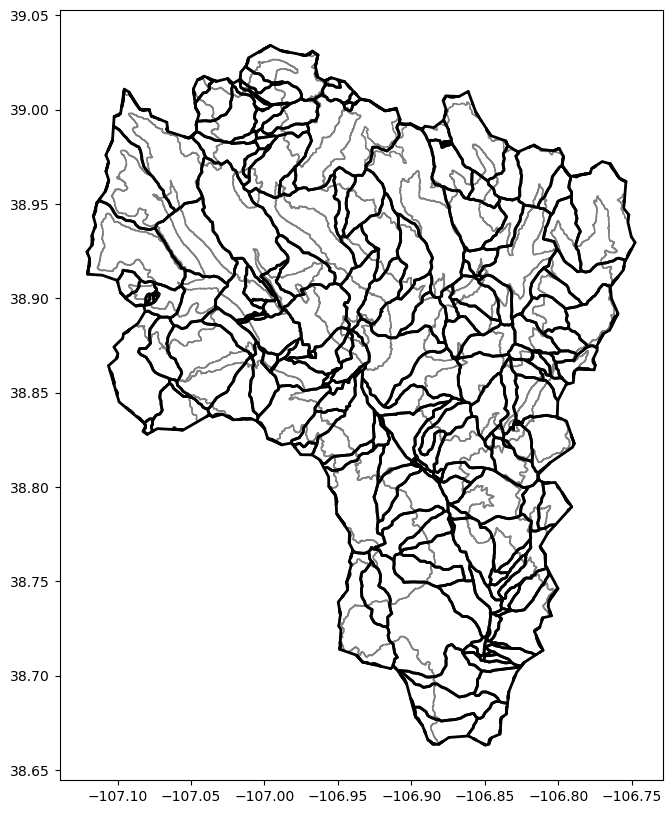

In [15]:
fig,ax=plt.subplots(figsize=(10,10))


gdf.boundary.plot(ax=ax, color='grey', lw=1)
subcatchments.boundary.plot(ax=ax, lw=2, color='black')